# Análisis de Transacciones Bancarias del Banco Birmingham City Council

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

d:\prueba tecnica idata\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_abril_df = pd.read_excel("../data/purchasecardtransactionsapril2014.xls")
raw_may_df = pd.read_excel("../data/purchasecardtransactionsmay2014.xls")
raw_june_df = pd.read_excel("../data/purchasecardtransactionsjune2014.xls")

In [3]:
raw_abril_df.sample(5)

,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
1050,2014-04-08,VZ,766.00,rising stars uk lt,************0628,GBP,L030,Books,REARX,Yew Tree Community Junior & Infant (NC),A00,CYP&F SCHOOLS
816,2014-04-21,VZ,2.08,tesco stores 5751,************7370,GBP,L220,Purchases Food,RV01E,264 Reservoir Road HLDC,A00,CYP&F
155,2014-04-24,VR,57.51,bp snax 24 weoley castle,************5638,GBP,K020,Vehicle Fuel,RV18X,Harborne Day Centre,A00,Adult & Communities
1083,2014-04-09,VZ,3.48,post office counter,************6067,GBP,L700,Postage,REAQB,The Oval Junior & Infant (NC),A00,CYP&F SCHOOLS
1039,2014-04-24,NaN,40.11,js online grocery,************9807,GBP,L220,Purchases Food,REARK,Wychall Farm JI,A5F,CYP&F SCHOOLS


Unifiquemos los tres dataframes para crear uno solo que sería un trimestre del año.

In [4]:
# verificación de que todas las columnas en los distintos dataframe tienen igual tipo de dato
raw_abril_df.dtypes == raw_may_df.dtypes
raw_abril_df.dtypes == raw_june_df.dtypes
raw_may_df.dtypes == raw_june_df.dtypes

TRANS DATE            True
TRANS VAT DESC        True
ORIGINAL GROSS AMT    True
MERCHANT NAME         True
CARD NUMBER           True
BILLING CUR CODE      True
TRANS CAC CODE 1      True
TRANS CAC DESC 1      True
TRANS CAC CODE 2      True
TRANS CAC DESC 2      True
TRANS CAC CODE 3      True
Directorate           True
dtype: bool

In [5]:
raw_trimestre = pd.concat([raw_abril_df, raw_may_df, raw_june_df], ignore_index=True)

### Análisis Exploratorio de Datos
Revisemos la calidad de los datos y si hay que tratarlos.

In [6]:
raw_trimestre.shape

(11836, 12)

In [7]:
(
    raw_trimestre
    .dtypes
    .value_counts()
)

object            10
datetime64[ns]     1
float64            1
Name: count, dtype: int64

La mayoría de columnas son de tipo objeto, esto significa que para  la búsqueda de patrones de grupos similares, tendremos que implementar posiblemente una encodización a la gran mayoría de columnas (one-hote encoder) para que sea más entendible por un algoritmo de segmentación.

Ahora revisemos los valores nulos.

In [8]:
(
    raw_trimestre
    .isnull()
    .sum()
)

TRANS DATE              0
TRANS VAT DESC        298
ORIGINAL GROSS AMT      0
MERCHANT NAME           0
CARD NUMBER             0
BILLING CUR CODE        0
TRANS CAC CODE 1        0
TRANS CAC DESC 1        0
TRANS CAC CODE 2        1
TRANS CAC DESC 2        1
TRANS CAC CODE 3        1
Directorate             0
dtype: int64

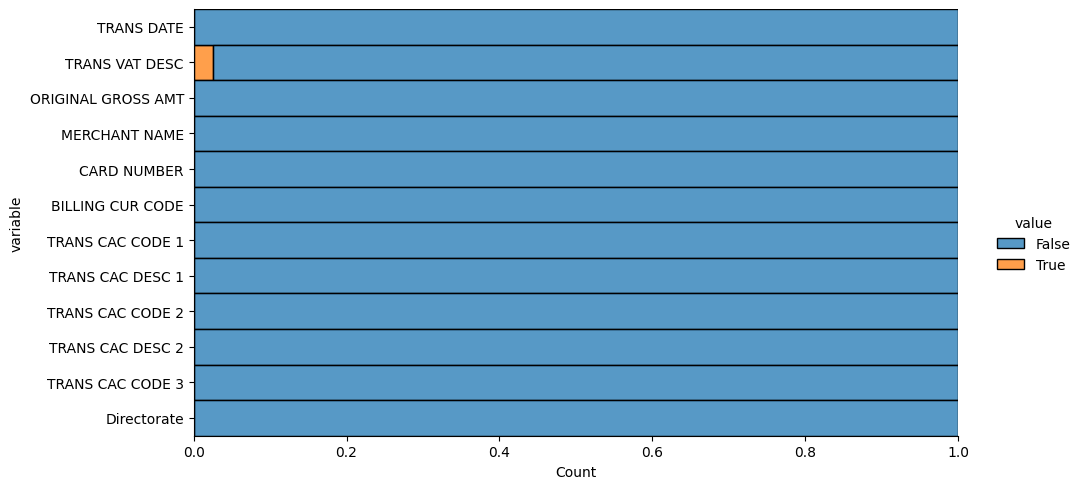

In [9]:
(
    raw_trimestre
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill', # para ver la proporción de las barras usamos 'fill'
                aspect=2 # aumentar el tamaño de la gráfica
            )
        )
    )
)

Al parecer la cantidad de valores nulos es baja y se concentra en una sola variable, entonces podemos presindir de estos datos para el estudio.

Aunque son pocos los valores nulos, no es buena opción eliminar toda la fila por estos, ya que contienen información importante de las demás variables y al eliminar estas filas perderíamos continuidad temporal en caso de desarrollar un tratamiento por serie de tiempos.

Los valores nulos se encuentran en variables tipo categórica, entonces se opta por llenar los valores nulos con la moda. Esta elección se toman dado el tipo de dato (object - categorico) para no añadir valores atípicos como valores representativos, si no que se añaden valores más usuales relacionados con las medidas de tendencia central que no afecten los datos.

In [10]:
mode_categoric_1 = raw_trimestre["TRANS VAT DESC"].mode()[0]
mode_categoric_2 = raw_trimestre["TRANS CAC CODE 2"].mode()[0]
mode_categoric_3 = raw_trimestre["TRANS CAC DESC 2"].mode()[0]
mode_categoric_4 = raw_trimestre["TRANS CAC CODE 3"].mode()[0]

raw_trimestre["TRANS VAT DESC"] = raw_trimestre["TRANS VAT DESC"].fillna(mode_categoric_1)
raw_trimestre["TRANS CAC CODE 2"] = raw_trimestre["TRANS CAC CODE 2"].fillna(mode_categoric_2)
raw_trimestre["TRANS CAC DESC 2"] = raw_trimestre["TRANS CAC DESC 2"].fillna(mode_categoric_3)
raw_trimestre["TRANS CAC CODE 3"] = raw_trimestre["TRANS CAC CODE 3"].fillna(mode_categoric_4)

In [11]:
raw_trimestre.describe(include=[np.number])

,ORIGINAL GROSS AMT
count,11836.000000
mean,146.362292
std,1582.635712
min,-1350.000000
25%,12.322500
50%,39.250000
75%,83.420000
max,54040.310000


En la documentación del banco Birmingham City Council, obtuvimos un documento que nos habla sobre las características de las tarjetas de compras, algunos puntos importantes se consignan en la documentación en el archivo modelo de informacion con el congenido general del analisis.

Las estadísticas para la variable numérica ORIGINAL GROSS AMT, que nos dice el monto de la transacción, se mantienen dentro de los valores estándar (tope máximo 500) a excepción del valor máximo que llega a niveles muy altos. Aquí ya se podría empezar a observar un posible valor atípico que se puede relacionar con fraude a menos de que sea un monto acordado con el banco y el propietario de la tarjeta.

In [12]:
raw_trimestre.describe(include=[object])

,TRANS VAT DESC,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
count,11836,11836,11836,11836,11836,11836,11836,11836,11836,11836
unique,7,1871,811,1,76,76,531,529,18,11
top,VZ,amazon mktplce eu-uk,************5412,GBP,K020,Vehicle Fuel,RUF0F,Illegal Money Lending T Stds Comm Inv.,A00,CYP&F SCHOOLS
freq,6690,1393,154,11836,1920,1920,1052,1052,11682,5608


Para los datos categóricos, se observa que hay un tipo común de impuesto de transacción (TRANS VAT DESC) que es el tipo VZ, además que el nombre de comercio es el aspecto que más datos distintos tiene, de esta variable se podrían observar situaciones atípicas si un usuario que normalmente compra en un lugar hace cambios a otros sin relación.

Es curioso ver que en una de las columnas, la característica que más se repite es Illegal Money Lending T Stds Comm Inv, haciendo referencia primero a que se trata de un lugar ilegal y segundo que puede ser una fuente de prestamos. Además, la transacción la hace un colegio, es decir que cuentan con una tarjeta virtual (vease documentación).

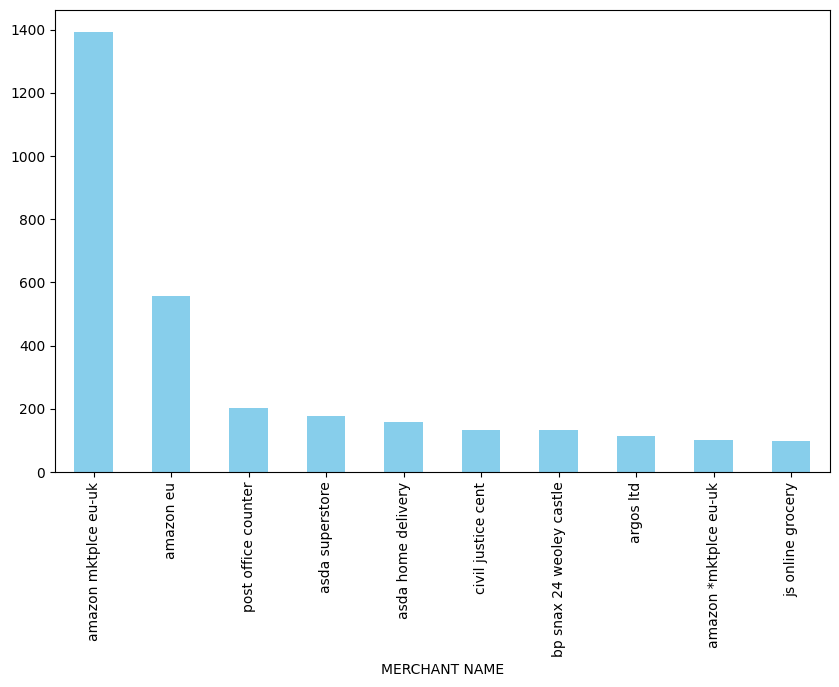

In [13]:
frecuencias = raw_trimestre["MERCHANT NAME"].value_counts()
frecuencias_principales = frecuencias.head(10)

plt.figure(figsize=(10, 6))
frecuencias_principales.plot(kind='bar', color='skyblue')
plt.show()

Al parecer el principal lugar de compras es el amazon mktplce eu-uk, en este lugar es más usual ver que se llevan acabo transacciones.

### Anomalías

Ahora analicemos el comportamiento de los valores de las compras con respecto a distintas clases, puede que con esto encontremos algún tipo de patrón, después de probar con distintas combinaciones de clases solo se dejarán las que más tengan sentido pero se probará con todas.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Adult & Communities'),
  Text(1, 0, 'Adults & Comms'),
  Text(2, 0, 'Corporate Resources'),
  Text(3, 0, 'CYP&F'),
  Text(4, 0, 'CYP&F  '),
  Text(5, 0, 'CYP&F SCHOOLS'),
  Text(6, 0, 'CYP&F Schools'),
  Text(7, 0, 'DEVELOPMENT'),
  Text(8, 0, 'Local Services'),
  Text(9, 0, 'Development'),
  Text(10, 0, 'Adults & Communities')])

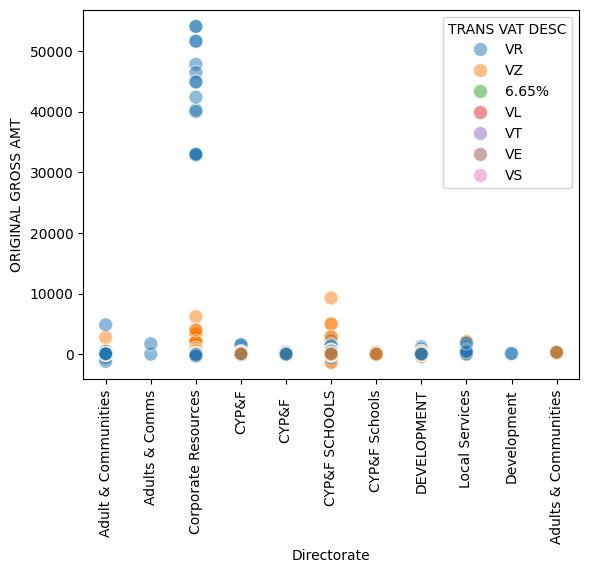

In [14]:
sns.scatterplot(
    data=raw_trimestre,
    x='Directorate',
    y='ORIGINAL GROSS AMT',
    alpha=1/2,
    hue='TRANS VAT DESC',
    s=100 # tamaño de los puntos, mientras menos puntos, más conviene aumentar el tamaño
)

plt.xticks(rotation=90)

Se observa la relación que hay entre los lugares que hacen las compras y el monto total de la transacción, clasificado por tipo de cobro de impuesto.

Vemos que hay una serie de valores atípicos relacionados con los valores de compra provenientes de Adults & Comms, también hay una leve variación para las compras provenientes de CYP&F SCHOOLS donde se supone que las ecuelas tienen montos bajos y el aumento supone una decisión que toma tiempo y debe ser verificada.

Revisemos el comportamiento de los valores atípicos de las transacciones, estos pueden ir de la mano con transacciones fraudulentas.

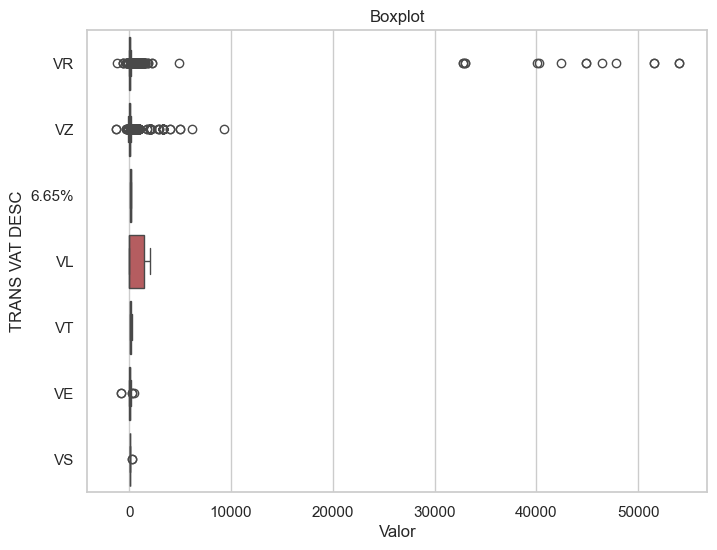

In [15]:
sns.set(style="whitegrid")

# Crea un boxplot con Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=raw_trimestre, x='ORIGINAL GROSS AMT', y='TRANS VAT DESC', hue='TRANS VAT DESC')
plt.title('Boxplot')
plt.xlabel('Valor')
plt.show()

Se observa que las transacciones con montos atípicos se encuentran en las que son hechas con tipo de taza de impuesto VR y VZ.

### Agrupamiento
Ahora seleccionemos las variables categóricas que más nos puedan servir para detectar patrones en los datos junto con la variable de monto transacciones.

Las variables elegidas son: TRANS CAC CODE 3, Directorate y TRANS VAT DESC. Por otra parte la columna BILLING CUR CODE tiene todos sus datos iguales, esta variable podría ser eliminada dado que no aporta nada al desarrollo.

In [16]:
raw_trimestre.columns

Index(['TRANS DATE', 'TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'MERCHANT NAME',
       'CARD NUMBER', 'BILLING CUR CODE', 'TRANS CAC CODE 1',
       'TRANS CAC DESC 1', 'TRANS CAC CODE 2', 'TRANS CAC DESC 2',
       'TRANS CAC CODE 3', 'Directorate'],
      dtype='object')

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

In [18]:
variable_numerica = ['ORIGINAL GROSS AMT']
variables_categoricas = ['TRANS VAT DESC', 'TRANS CAC CODE 3', 'Directorate']

# escalamiento de la variable numérica
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# encodización variables categóricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
# trimestre_df = raw_trimestre[['ORIGINAL GROSS AMT', 'TRANS VAT DESC', 'TRANS CAC CODE 3', 'Directorate']]
trimestre_df = raw_trimestre.copy()

In [20]:
# tratamiento de valores atípicos
for var in variable_numerica:
    Q1 = trimestre_df[var].quantile(0.25)
    Q3 = trimestre_df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    trimestre_df[var] = trimestre_df[var].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

In [21]:
# implementamos las transformaciones previas para variables numéricas y categóricas
tratamiento = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, variable_numerica),
        ('cat', categorical_transformer, variables_categoricas)
    ])

Antes de implementar el algoritmo de cluster, miremos cuántos clusters se pueden crear basados en el método del codo.

d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

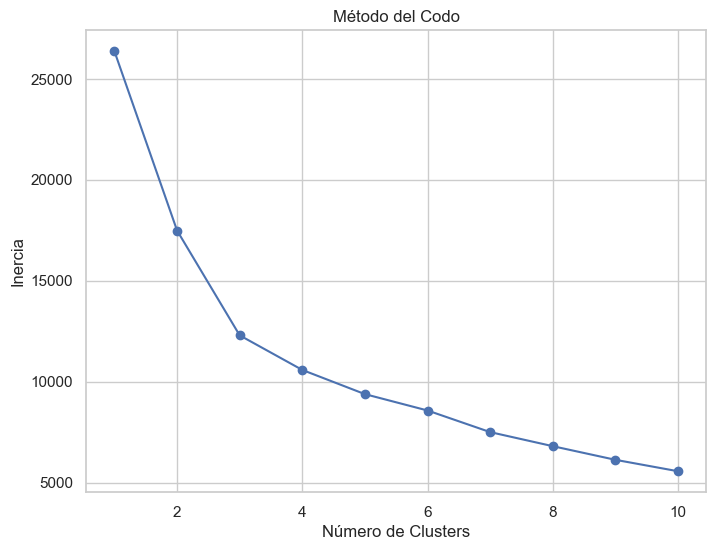

In [22]:
inercias = []

# Prueba con diferentes números de clusters (de 1 a 10, por ejemplo)
for i in range(1, 11):
    # Crea un pipeline con el preprocesamiento y el algoritmo de clustering (K-means)
    pipeline = Pipeline(steps=[
        ('preprocessor', tratamiento),
        ('cluster', KMeans(n_clusters=i, random_state=42))
    ])
    
    # Aplica el pipeline al DataFrame
    df_codo = pipeline.fit(trimestre_df[variable_numerica+variables_categoricas])
    
    # Almacena la inercia
    inercias.append(pipeline.named_steps['cluster'].inertia_)

# Grafica la curva del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inercias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

Para determinar el número de clusters adecuados para el modelo de agrupación, debemos observar en la gráfica el momento en que esta toma un cambio brusco de trayectoria. Debemos observar cuál es el nodo (punto) en donde se da dicho cambio, para este caso se ve que en el nodo numero 3 se genera un fuerte cambio, por lo tanto se sugiere implementar el modelo con n=3 clusters.

In [23]:
# creación del pipeline para generar el cluster con el algoritmo K-Means
pipeline = Pipeline(steps=[
    ('preprocessor', tratamiento),
    ('cluster', KMeans(n_clusters=3, random_state=42))])

In [24]:
trimestre_cluster = pipeline.fit_transform(trimestre_df[variable_numerica+variables_categoricas])

trimestre_df['cluster'] = pipeline.named_steps['cluster'].labels_

d:\prueba tecnica idata\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Ya hemos desarrollado el algoritmo de agrupación con 3 clusters, ahora miremos cómo se comportan las distintas variables implicadas con respecto a estos grupos.

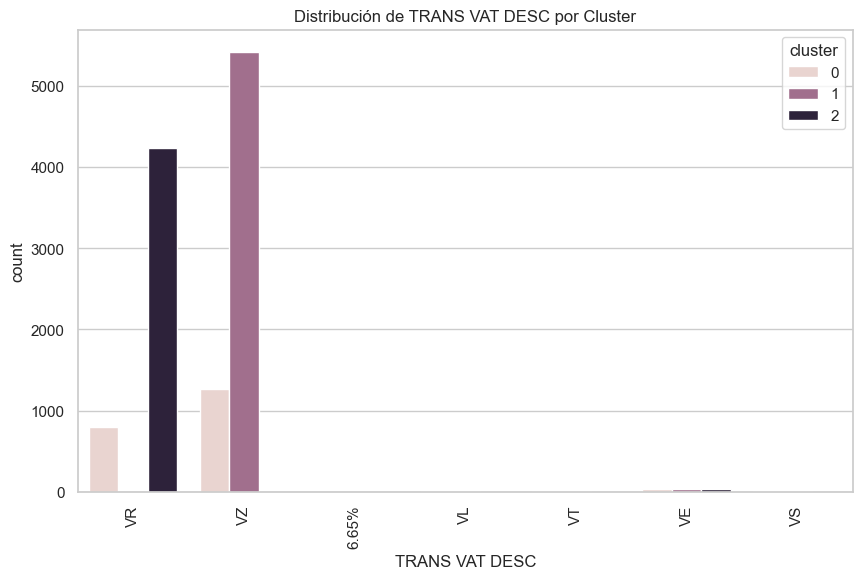

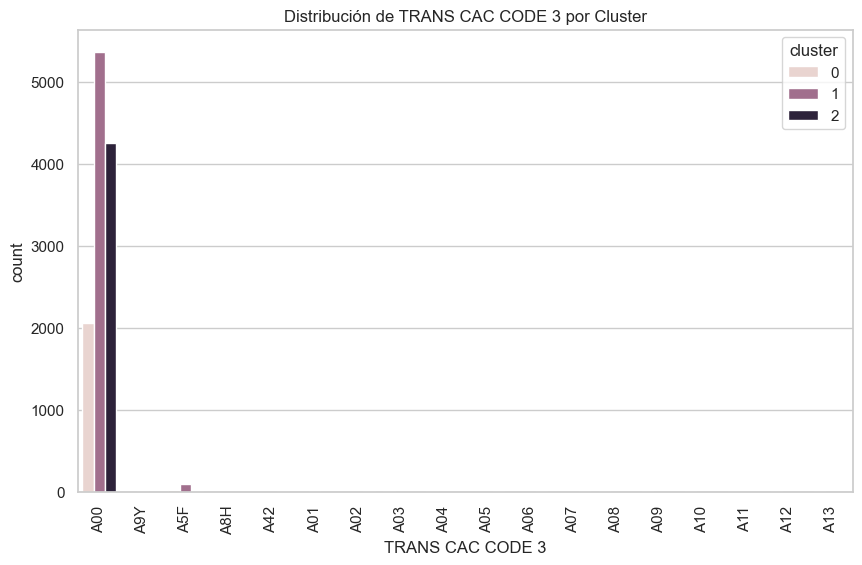

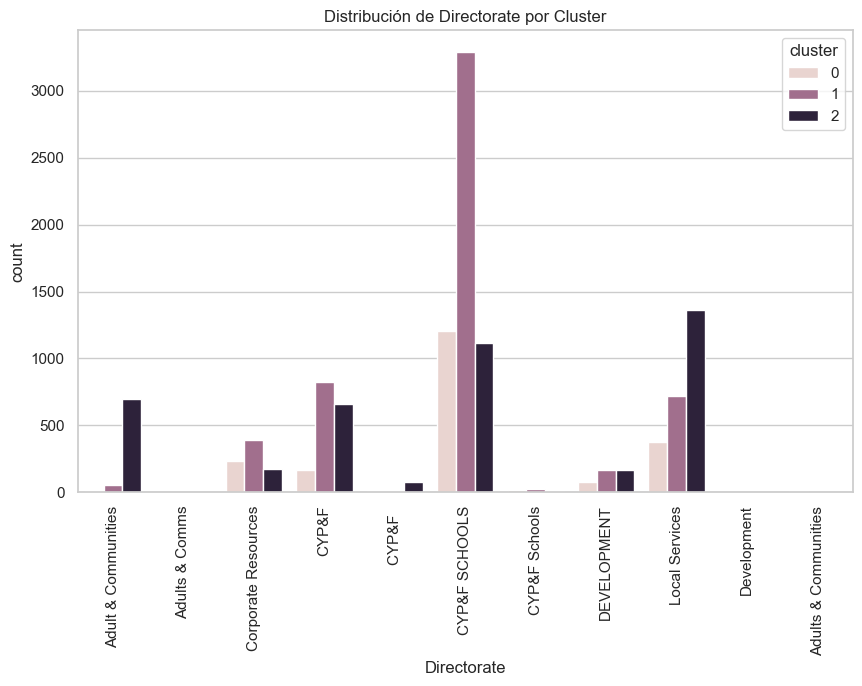

In [25]:
for var in variables_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, hue='cluster', data=trimestre_df)
    plt.title(f'Distribución de {var} por Cluster')
    plt.xticks(rotation=90)
    plt.show()

Se observa que el cluster predominante es el 1, seguido por el cluster 2 y finalmente el cluster 0. 

Según la gráfica de Directorate (Dirección), el cluster 0 predomina en transacciones que provienen de una tarjeta con dirección de propietario desde la CYP&F SCHOOL es decir desde colegios, por otra parte la gráfica de TRANS VAT DESC (tipo de cobro impuesto) en el cluster 0 predomina el tipo VZ que esta asociado con escuelas. Por lo tanto, el cluster 0 lo podemos relacionar con una tarjeta de compras privada, dado que según la documentación de tarjetas de compra las tarjetas privadas son las correspondientes a colegios.

Por otra parte, el cluster 2, tiene mayor relación con compras desde servicios locales y otro tipo de direcciones de pago como comunidades. Por lo tanto, el cluster 2 se relaciona con pagos de tarjeta tipo compras individuales.

El cluster 0, tiene una relación con los otros dos clusteres, teniendo una relación principalmente con el cluster 2, por lo tanto podemos hablar de que los clientes con estas compras pueden manejar similar tipo de tarjeta.

Como estamos comparando el monto de las compras, no sabemos directamente si se tratan de un tipo u otro de tarjetas, pero con la clusterización hecha es evidente por ejemplo la tendencia del cluster 0 a representar los clientes de escuelas que usan las llamadas tarjetas de compras virtuales.

NOTA: si el código vuelve a correr reiniciando todo, es posible que el orden de los clusteres cambie pero los 3 presentarán los comportamientos descritos aquí solo que con diferente asignación de número. De igual forma, en el algoritmo K-Means se plantó una semilla para reproducir el mismo resultado si se corre varias veces dentro de la misma sesión.

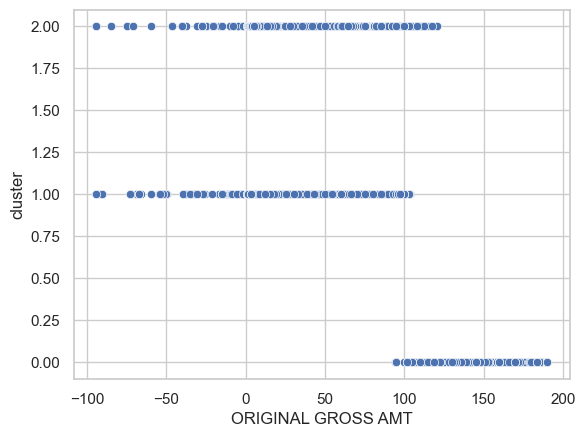

In [26]:
sns.scatterplot(x=variable_numerica[0], y='cluster', data=trimestre_df)
plt.show()

Observando la distribución de las transacciones con respecto a los clusteres creados, vemos que el cluster 1 es el que cuenta con la mayor cantidad de valores altos, que incluso se podrían considerar como atípicos dado que el cluster 1 y el 2 tienen similares valores.

Así nos podríamos preguntar si en el cluster 0 se encuentran los clientes que han hecho transacciones ilegales o inadecuadas, este es un método de detección de anomalías y por lo tanto posibles fraudes.

Ahora bien, antes de iniciar con un modelo de predicción sobre compras, analizando los datos se encuentra que hay clientes que realizan más de una transacción por día.

In [27]:
df_ordenado = trimestre_df.sort_values('TRANS DATE').copy()
df_ordenado = df_ordenado.set_index('TRANS DATE')

In [28]:
clientes_multitrans = df_ordenado.groupby(['CARD NUMBER', df_ordenado.index.date]).size().reset_index(name='num_transacciones')
clientes_multitrans = clientes_multitrans[clientes_multitrans['num_transacciones'] > 1]
clientes_multitrans = clientes_multitrans.sort_values(by='num_transacciones', ascending=False)

Entonces, los siguientes clientes realizan más de una transacción por día, son clientes que se deben analizar con cuidado porque pueden ser objeto de fraude.

In [29]:
clientes_multitrans

,CARD NUMBER,level_1,num_transacciones
1137,************2700,2014-06-06,28
4523,************8956,2014-06-24,20
321,************0754,2014-06-03,20
2193,************4428,2014-06-25,18
333,************0770,2014-04-24,18
...,...,...,...
1940,************4136,2014-06-26,2
1943,************4138,2014-06-18,2
1944,************4138,2014-06-23,2
1947,************4139,2014-06-04,2


# Pronóstico de Próximo Gasto por cliente

Ahora creamos un modelo de pronóstico o forecasting, ya que tenemos las fechas de las compras podemos crear una nueva columna que tenga el valor del monto de la próxima compra para que nos ayude como variable objetivo. Además, dejamos solo un acumulado por día de monto de los clientes y también creamos otra columna numérica que nos diga la frecuencia de compra para posibles análisis o implementación como variable exógena de el entrenamiento.

Primero demosle un nombre a las categorías que nos creo el cluster y cambiemosle el nombre a tipo_cliente_monto, el cual contendra los monto_0, 1 ó 2, que generó el cluster.

In [30]:
trimestre_df['cluster'] = trimestre_df['cluster'].replace({0: 'monto_0', 1: 'monto_1', 2: 'monto_2'})

# Renombrar la columna
trimestre_df = trimestre_df.rename(columns={'cluster': 'tipo_cliente_monto'})

In [31]:
trimestre_df.columns

Index(['TRANS DATE', 'TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'MERCHANT NAME',
       'CARD NUMBER', 'BILLING CUR CODE', 'TRANS CAC CODE 1',
       'TRANS CAC DESC 1', 'TRANS CAC CODE 2', 'TRANS CAC DESC 2',
       'TRANS CAC CODE 3', 'Directorate', 'tipo_cliente_monto'],
      dtype='object')

In [32]:
entrenamiento_df = trimestre_df[['CARD NUMBER', 'TRANS DATE', 'ORIGINAL GROSS AMT', 'TRANS VAT DESC', 'TRANS CAC CODE 3', 'Directorate', 'tipo_cliente_monto']].copy()

### Preparación del dataframe

In [33]:
# convertimos la columna fecha a tipo numérica para que se pueda usar en el modelo de mejor forma
# entrenamiento_df['TRANS DATE'] = pd.to_numeric(entrenamiento_df['TRANS DATE']) 

# ordenamos el dataframe por fecha y numero de tarjeta del cliente que será nuestro ID
entrenamiento_df = entrenamiento_df.sort_values(by=['CARD NUMBER', 'TRANS DATE'])

# creamos una nueva columna que se llame FRECUENCIA, para ayudar al modelo a predecir esto es
# parte de feature engenerie
# Se usa diff para calcular la cantidad de días entre una compra y otra
entrenamiento_df['FRECUENCIA'] = entrenamiento_df.groupby('CARD NUMBER')['TRANS DATE'].diff().dt.days

se han creado valores con NaN en la frecuencia porque los primeros días no tienen un día anterior para poder
calcular la diferencia entre un día de compra y el siguiente, entonces borramos estos datos.

In [34]:
entrenamiento_df = entrenamiento_df.dropna(subset=['FRECUENCIA'])

Ahora creamos nuestra columna objetivo o target, esta corresponde a la compra del día siguiente para los clientes, la llamaremos MONTO_PROXIMA_COMPRA.

In [35]:
# Crear una columna 'MONTO_PROXIMA_COMPRA' sumando los montos de todas las compras del próximo día
entrenamiento_df['MONTO_PROXIMA_COMPRA'] = entrenamiento_df.groupby('CARD NUMBER')['ORIGINAL GROSS AMT'].shift(-1)
entrenamiento_df['MONTO_PROXIMA_COMPRA'] = entrenamiento_df.groupby(['CARD NUMBER', entrenamiento_df['TRANS DATE'].dt.date])['MONTO_PROXIMA_COMPRA'].transform('sum')

Como el último cliente no tiene próxima compra porque no tenemos el dato, eliminamos esta fila sin datos.

In [36]:
entrenamiento_df = entrenamiento_df.dropna(subset=['MONTO_PROXIMA_COMPRA'])

Como vamos a trabajar con un modelo de series de tiempo forecasting, debemos tener ordenados de forma secuencial la variable tiempo, ademáss la pondremos como índice.

Para esto, en donde un cliente tenga más de una compra por fecha solo dejaremos los datos categóricos de moda y en numérica los datos de media.

In [37]:
df_resultados_procesado = entrenamiento_df.groupby('TRANS DATE').agg({
    'TRANS VAT DESC': lambda x: x.mode().iloc[0],  # Moda para variables categóricas
    'TRANS CAC CODE 3': lambda x: x.mode().iloc[0],  # Moda para variables categóricas
    'Directorate': lambda x: x.mode().iloc[0],  # Moda para variables categóricas
    'tipo_cliente_monto': lambda x: x.mode().iloc[0],  # Moda para variables categóricas
    'FRECUENCIA': 'sum',  # Suma para variables numéricas
    'ORIGINAL GROSS AMT': 'sum'  # Suma para variables numéricas
}).reset_index()

In [38]:
datos = df_resultados_procesado.set_index('TRANS DATE') # columna fecha como índice
datos = datos.asfreq('D') # organizamos los datos con frecuencia diaria dado el tipo de datos que tenemos
datos = datos.sort_index()
datos.head()

,TRANS VAT DESC,TRANS CAC CODE 3,Directorate,tipo_cliente_monto,FRECUENCIA,ORIGINAL GROSS AMT
TRANS DATE,,,,,,
2014-04-02,VZ,A00,Corporate Resources,monto_0,0.0,190.06625
2014-04-03,VZ,A00,Local Services,monto_2,31.0,2260.69125
2014-04-04,VZ,A00,Local Services,monto_1,23.0,3732.83625
2014-04-05,VR,A00,CYP&F SCHOOLS,monto_1,19.0,1307.18625
2014-04-06,VZ,A00,CYP&F SCHOOLS,monto_1,17.0,768.70250


In [39]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.2903225806451613


verificamos que se encuentre el índice completo

In [40]:
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

Ahora separemos y visualicemos los datos que se usarán para entrenamiento y test

Fechas train : 2014-04-02 00:00:00 --- 2014-06-18 00:00:00  (n=78)
Fechas test  : 2014-06-19 00:00:00 --- 2014-07-03 00:00:00  (n=15)


C:\Users\diego\AppData\Local\Temp\ipykernel_6664\2431061724.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  datos.interpolate(method='linear', inplace=True)


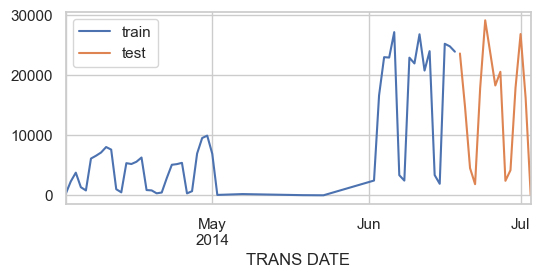

In [41]:
steps = 15 # se usa un entrenamiento con ventana de 15 días
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
datos.interpolate(method='linear', inplace=True)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['ORIGINAL GROSS AMT'].plot(ax=ax, label='train')
datos_test['ORIGINAL GROSS AMT'].plot(ax=ax, label='test')
ax.legend();

Como se puede observar en la gráfica, hay una amplia zona inconsistente, esto se debe a que en esta parte hay un faltante de datos. Por tal motivo, fue necesario completar la zona ausente con una regresión lineal que completara esta parte.

Tal vez si se amplía el conjunto de datos y utiliza una mayor cantidad de datos, el tipo de frecuencia aumente y no existan tantos vacíos. Todo depende de la calidad de la recolección de datos.

Ahora entrenamos el modelo en base a nuestros datos, en este caso usaremos un Random Forest, esto por su facilidad de entendimiento, este funciona como una serie de condicionales que dividen los datos. Además evita el overfitting en la data.

Para el entrenamiento en este caso, solo necesitaremos del índice temporal y la variable objetivo, en un principio no implementaremos las demás variables.

In [42]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['ORIGINAL GROSS AMT'])

Imprimamos los

In [43]:
steps = 15
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2014-06-19    14189.798638
2014-06-20    13082.579563
2014-06-21    14673.272925
2014-06-22    21746.426087
2014-06-23    23674.168525
Freq: D, Name: pred, dtype: float64

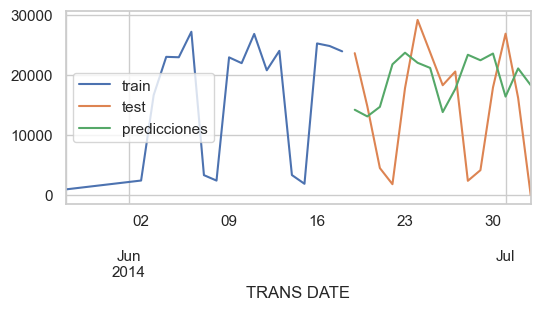

In [44]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['ORIGINAL GROSS AMT'][55:].plot(ax=ax, label='train')
datos_test['ORIGINAL GROSS AMT'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

Los primeros resultados no nos dan una predicción muy óptima, esta puede mejorar en la medida que entrenemos el modelo con mejores hiperparametros, sin embargo se debe recordar que la calidad de los datos no es la mejor, tomando una mayor cantidad de datos en un computo más grande se podría generar un resultado mejor.

In [45]:
error_mse_1 = mean_squared_error(
                y_true = datos_test['ORIGINAL GROSS AMT'],
                y_pred = predicciones[:len(datos_test)]
            )

print(f"Error de test (mse): {error_mse_1}")

Error de test (mse): 132340470.29936507


Vemos que las métricas no son las mejores por ahora.

Haciendo un entrenamiento de hiperparámetros donde obtengamos los mejores hiperparámetros para entrenar el modelos tenemos

In [46]:
steps = 15
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['ORIGINAL GROSS AMT'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 128679452.50561985



In [47]:
regressor_mejorado = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=45)
forecaster_mejorado = ForecasterAutoreg(
                regressor = regressor_mejorado,
                lags      = 20
             )

forecaster_mejorado.fit(y=datos_train['ORIGINAL GROSS AMT'])

In [48]:
predicciones_2 = forecaster_mejorado.predict(steps=steps)

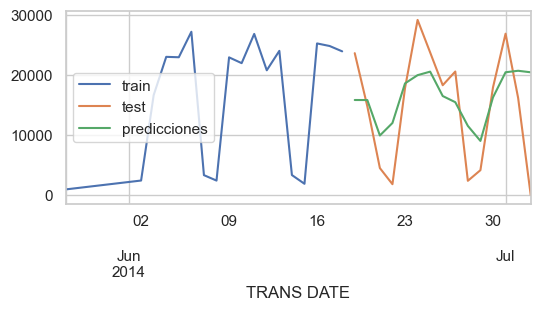

In [49]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['ORIGINAL GROSS AMT'][55:].plot(ax=ax, label='train')
datos_test['ORIGINAL GROSS AMT'].plot(ax=ax, label='test')
predicciones_2.plot(ax=ax, label='predicciones')
ax.legend();

In [50]:
error_mse_2 = mean_squared_error(
                y_true = datos_test['ORIGINAL GROSS AMT'],
                y_pred = predicciones_2[:len(datos_test)]
            )

print(f"Error de test (mse): {error_mse_2}")

Error de test (mse): 60429684.87167385


Ahora podemos observar que la gráfica de predicción apunta a tomar más la forma de los datos reales, se puede seguir ampliando la afinación del modelo como por ejemplo implementando más datos para el modelo sin vacíos para el modelo y mayor tiempo en meses, en este caso se usaron tres meses.

# Problematica

Supongamos que queremos hacer una predicción de cómo será el comportamiento de las ventas en días posteriores a los datos que conocemos, nosotros siendo representantes de la entidad bancaria debemos plantear un método para pronosticar esto.

Es así, como podemos crear una función que se apropie del entrenamiento que se llevó a cabo.

In [51]:
def predict_future_dates(forecaster, steps):
    """
    Realiza predicciones para un número específico de pasos hacia adelante.

    Parameters:
        - forecaster (ForecasterAutoreg): Modelo entrenado.
        - steps (int): Número de pasos hacia adelante que se quieren pronosticar.

    Returns:
        - predictions_df (pd.DataFrame): DataFrame con fechas y predicciones.
    """
    last_date = forecaster.__dict__['last_window'].index[-1]
    date_range = pd.date_range(start=last_date, periods=steps + 1, freq='D')[1:]

    predictions = forecaster.predict(steps=steps)

    predictions_df = pd.DataFrame({
        'Fecha': date_range,
        'Predicciones': predictions
    })

    return predictions_df

Por ejemplo queremos pronosticar cuales serán los montos de compras en los próximos 10 días

In [52]:
steps=10

# Hacer predicciones para el rango de fechas específico
predictions_result_df = predict_future_dates(forecaster_mejorado, steps)

print(predictions_result_df)

                Fecha  Predicciones
2014-06-19 2014-06-19  15812.211387
2014-06-20 2014-06-20  15804.304140
2014-06-21 2014-06-21   9912.369791
2014-06-22 2014-06-22  11989.964380
2014-06-23 2014-06-23  18576.907280
2014-06-24 2014-06-24  19942.871386
2014-06-25 2014-06-25  20529.098344
2014-06-26 2014-06-26  16472.038103
2014-06-27 2014-06-27  15447.259394
2014-06-28 2014-06-28  11505.207268


Así podemos tener un elemento que nos ayude a planear las compras que se harán en los próximos días con nuestra tarjeta, partiendo del último día conocido por el modelo.

Una vez que se suba a producción este modelo varias cosas cambiarán para mejor:
- Se entrenará con más datos, lo que mejorará el rendimiento y métricas.
- El modelo será aun más preciso y se tendrá un punto de referencia que es el modelo inicial, osea el presentado aquí.
- Desde gerencia, se podrá hacer un plan de trabajo con el cual sea posible tomar medidas preventivas o acciones en caso de encontrar anomalías.